In [1]:
#We import the necessary libraries.
import pandas as pd
from tqdm import tqdm; tqdm.pandas()
from collections import Counter
import pyreadstat
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadstat
from statsmodels.othermod.betareg import BetaModel
from scipy.stats import shapiro, kstest
from matplotlib.ticker import FuncFormatter

## preprocessing

In [2]:
#We read in our complete data file.
df = pd.read_csv("04_contents_clean_w_nos.csv", index_col=0)

In [3]:
#We look at the size for each outlet.
df.groupby("news_source").size()

news_source
AD            4897
NOS           4997
NRC           4516
NU            4868
Telegraaf     4929
Volkskrant    4694
dtype: int64

In [4]:
#We calculate the presence of soft and hard articles.
round(df.p_article_softness.value_counts(normalize=True)*100, 2)

p_article_softness
hard    60.53
soft    39.47
Name: proportion, dtype: float64

In [5]:
#We count the presence of textual error corrections.
Counter(df.error_correction)

Counter({False: 28678, True: 223})

In [6]:
#We downsample to the least present outlet.
df = df.groupby("news_source").sample(min(df.groupby("news_source").size()), random_state=1)

In [8]:
#We assess the length of the dataframe.
len(df)

27096

In [9]:
#We look at all columns.
df.columns

Index(['index', 'news_source', 'links', 'retrieval_time', 'errors',
       'txt_author', 'txt_author_links', 'txt_timestamps', 'txt_text',
       'hyperlinks', 'comments', 'isAccessibleForFree', 'headline',
       'datePublished', 'dateModified', 'author', 'articleBody',
       'articleSection', 'txt_text_clean', 'txt_text_one', 'text_length',
       'hyperlinks_clean', 'n_hyperlinks', 'dateMonth', 'author_clean',
       'author_categories', 'tp_authors', 'author_additions', 'tp_contact',
       'tp_bio', 'txt_timestamps_clean', 'txt_timestamps_cat', 'changed',
       'tp_timestamp', 'error_correction', 'tp_error', 'link_stems',
       'data_types', 'hyperlinks_cat', 'tp_internal', 'tp_document',
       'tp_family', 'tp_external', 'intro', 'intro_sentences',
       'intro_1st_5_sent', 'self_referral_presence', 'self_referral_text',
       'process_info_factor', 'tp_comments', 'np_funding', 'np_mode',
       'np_quality', 'section_clean', 'article_softness', 'p_article_softness',
      

In [10]:
#We assess the average text length of each outlet.
df.groupby("news_source").text_length.mean()

news_source
AD            2715.923384
NOS           2388.043623
NRC           3222.177369
NU            2264.193091
Telegraaf      695.550266
Volkskrant    3393.025244
Name: text_length, dtype: float64

In [11]:
#We define a custom color palette.
custom_palette = ["#D10A10", "#949494", "#F5F1E5", "#020051", "#27509A", "#000000"]

import matplotlib.font_manager
font_names = [f.name for f in matplotlib.font_manager.fontManager.ttflist]
print(font_names)

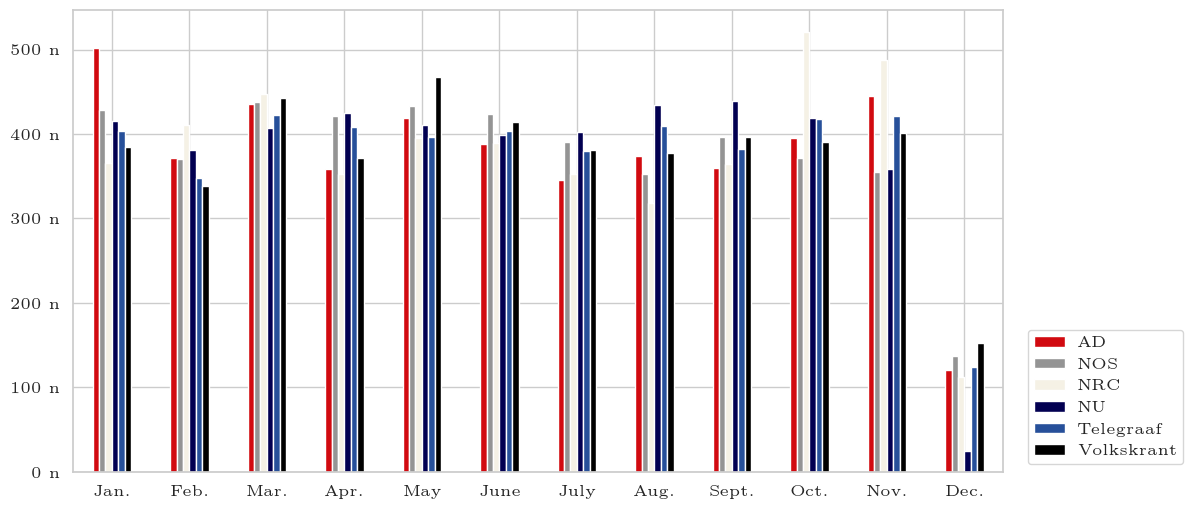

In [13]:
#We set the font.
plt.rcParams['font.family'] = ['Latin Modern Roman']
#We create a pivot table with the size of each outlet in each month.
pivot_df = df.pivot_table(index="dateMonth", columns="news_source", aggfunc="size", fill_value=0) 
fig, ax = plt.subplots(figsize=(12, 6))
#We set our colors.
sns.set(font_scale=1, palette=custom_palette, style="whitegrid")
#We plot our pivotted table as a barplot.
pivot_df.plot(kind="bar", stacked=False, ax=ax)
legend = ax.legend(bbox_to_anchor=(1.11, 0), loc="lower center", ncol=1)
for text in legend.get_texts():
    text.set_fontfamily("Latin Modern Roman")
ax.set_xlabel("")
def format_n(value, _):
    return f"{value:.0f} n"
ax.yaxis.set_major_formatter(FuncFormatter(format_n))
plt.xticks(rotation=0)
ax.set_xticklabels(["Jan.", "Feb.", "Mar.", "Apr.", "May", "June", "July", "Aug.", "Sept.", "Oct.", "Nov.", "Dec."])
plt.savefig("month_dist.pdf", format="pdf", bbox_inches="tight")

In [15]:
#We transform the datePublished to an actual datetime object.
df["datePublished"] = pd.to_datetime(df.datePublished,  format="mixed", utc=True)

In [16]:
#We extract the hour of the day of the publication.
df["pub_hour"] = df.datePublished.dt.hour

<Axes: >

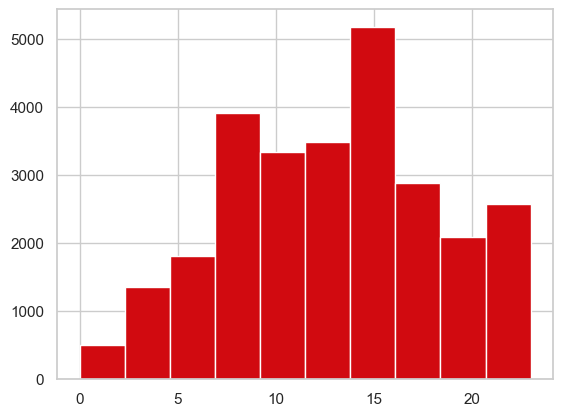

In [17]:
#We plot the distribution of it.
df["pub_hour"].hist()

In [18]:
#We assess the median value of publications per hour.
pub_hour_median = df["pub_hour"].value_counts(sort=True).median()

In [19]:
#We assses whether each hour is above or below the median value.
pub_hour_dict = dict(df["pub_hour"].value_counts(sort=True) > pub_hour_median)

In [20]:
#We define a function to loop over the above defined dictionary.
def get_peak_hour(x, dist=pub_hour_dict):
    #Namely we loop over the dictionary until we find the hour of the publication.
    #And then we send back the value that is related to it.
    for key, value in dist.items():
        if x == key:
            return value
            break
        else:
            continue

In [21]:
#We apply the peak hour function and return it as a column.
df["peak_hour"] = df.pub_hour.progress_apply(lambda x: get_peak_hour(x))

100%|████████████████████████████████████████████████████████████████████████| 27096/27096 [00:00<00:00, 788915.92it/s]


In [19]:
df.peak_hour.values

array([ True,  True, False, ...,  True,  True,  True])

In [22]:
#We extract the day of the week of publication.
df["pub_day"] = df.datePublished.dt.day_name()

In [23]:
#We assess the size for each day.
dict(df["pub_day"].value_counts(sort=True))

{'Thursday': 4766,
 'Wednesday': 4226,
 'Friday': 4204,
 'Tuesday': 4103,
 'Monday': 3943,
 'Sunday': 3318,
 'Saturday': 2536}

In [24]:
#We make a simple function to assess whether the day is part of the weekend.
def get_weekend(x):
    if x in ["Saturday", "Sunday"]:
        return True
    else:
        return False

In [25]:
#We create a column to define this.
df["weekend"] = df.pub_day.progress_apply(lambda x: get_weekend(x))

100%|███████████████████████████████████████████████████████████████████████| 27096/27096 [00:00<00:00, 1754138.22it/s]


In [26]:
Counter(df.weekend)

Counter({False: 21242, True: 5854})

In [36]:
#We create a new dataframe with all variables that we need for our analyses.
tp = df[["news_source", "np_funding", "np_mode", "np_quality", "p_article_softness",
         "author_clean", "section_clean", "dateMonth",
         "text_length", "peak_hour", "weekend",
         "tp_authors", "tp_contact", "tp_bio",
         "tp_timestamp_w_nos", "tp_error", "changed_w_nos",
         "tp_internal", "tp_document", "tp_family", "tp_external", 
         "tp_sourcing",
         "process_info_factor"]]

In [37]:
#We define a minmaxscaler.
scaler = MinMaxScaler()

#We define a function to recode variables to dummies containing explicit as their highest transparency category.
def recode_explicit(x):
    if x == "explicit":
        return 1
    else:
        return 0

#We create a function to transform a boolean variable to a numeric dummy.
def recode_boolean(x):
    if x == True:
        return 1
    else:
        return 0

#In specific for change disclosure we create a numeric dummy transformation function.
def recode_change_disclosure(x):
    if x == "change disclosed":
        return 1
    else:
        return 0

#We also do so for numeric values.
def recode_numeric(x):
    if x == 0:
        return 0
    else:
        return 1

In [38]:
#We transform explicit sourcing en author transparency to dummies.
tp[["tp_authors",  "explicit_sourcing"]] = tp[["tp_authors", "tp_sourcing"]].progress_applymap(recode_explicit)

100%|███████████████████████████████████████████████████████████████████████| 54192/54192 [00:00<00:00, 1551901.64it/s]
C:\Users\dubel\AppData\Local\Temp\ipykernel_9444\2233665232.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp[["tp_authors",  "explicit_sourcing"]] = tp[["tp_authors", "tp_sourcing"]].progress_applymap(recode_explicit)
C:\Users\dubel\AppData\Local\Temp\ipykernel_9444\2233665232.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp[["tp_authors",  "explicit_sourcing"]] = tp[["tp_autho

In [39]:
#We transform the boolean variables to dummies.
tp[["tp_contact", "tp_bio"]] = tp[["tp_contact", "tp_bio"]].progress_applymap(recode_boolean)

100%|███████████████████████████████████████████████████████████████████████| 54192/54192 [00:00<00:00, 1498425.89it/s]
C:\Users\dubel\AppData\Local\Temp\ipykernel_9444\580812465.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp[["tp_contact", "tp_bio"]] = tp[["tp_contact", "tp_bio"]].progress_applymap(recode_boolean)


In [40]:
#We transform the update disclosure variables to dummies.
tp[["tp_timestamp_w_nos", "tp_error"]] = tp[["tp_timestamp_w_nos", "tp_error"]].progress_applymap(recode_change_disclosure)

100%|███████████████████████████████████████████████████████████████████████| 54192/54192 [00:00<00:00, 1503510.58it/s]
C:\Users\dubel\AppData\Local\Temp\ipykernel_9444\2018185256.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp[["tp_timestamp_w_nos", "tp_error"]] = tp[["tp_timestamp_w_nos", "tp_error"]].progress_applymap(recode_change_disclosure)


In [41]:
#We combine the internal and family variables.
tp["tp_internal_and_family"] = tp.tp_internal + tp.tp_family

C:\Users\dubel\AppData\Local\Temp\ipykernel_9444\1954625419.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp["tp_internal_and_family"] = tp.tp_internal + tp.tp_family


In [42]:
#We recode all numeric variables to dummies.
tp[["tp_internal",
    "tp_document",
    "tp_family",
    "tp_external",
    "tp_internal_and_family",
    "tp_process_info"]] = tp[["tp_internal",
                                     "tp_document",
                                     "tp_family",
                                     "tp_external", 
                                     "tp_internal_and_family",
                                     "process_info_factor"]].progress_applymap(recode_numeric)

100%|█████████████████████████████████████████████████████████████████████| 162576/162576 [00:00<00:00, 1520759.09it/s]
C:\Users\dubel\AppData\Local\Temp\ipykernel_9444\1498052201.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp[["tp_internal",
C:\Users\dubel\AppData\Local\Temp\ipykernel_9444\1498052201.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp[["tp_internal",


In [43]:
#For each dummy transparency indicator we calculate its relative prevalence over the entire data.
tp_n = tp.drop(columns=["process_info_factor", "text_length", "dateMonth"]).select_dtypes(include="number").apply(lambda col: col.value_counts(normalize=True)); tp_n

,tp_authors,tp_contact,tp_bio,tp_timestamp_w_nos,tp_error,tp_internal,tp_document,tp_family,tp_external,explicit_sourcing,tp_internal_and_family,tp_process_info
0,0.477008,0.96601,0.72734,0.71457,0.992139,0.765537,0.979259,0.973133,0.820306,0.594147,0.746974,0.948332
1,0.522992,0.03399,0.27266,0.28543,0.007861,0.234463,0.020741,0.026867,0.179694,0.405853,0.253026,0.051668


In [44]:
#We try to normalize the weight by taking the logarithm plus 1 for each of the needed transparency indicators.
tp_weights = tp_n[:1].apply(lambda x: np.log(1 + x)).drop(columns=["tp_family", "tp_internal"]); tp_weights

,tp_authors,tp_contact,tp_bio,tp_timestamp_w_nos,tp_error,tp_document,tp_external,explicit_sourcing,tp_internal_and_family,tp_process_info
0,0.390018,0.676006,0.546583,0.539163,0.689209,0.682722,0.599004,0.466339,0.557885,0.666974


In [45]:
#We rename all the weights to full names.
tp_weights_table = tp_weights.rename(columns={"tp_authors":"explict author(s)",
                                              "tp_contact":"contact information",
                                              "tp_bio":"biographic information",
                                              "tp_timestamp_w_nos":"timestamp disclosure",
                                              "tp_error":"textual disclosure",
                                              "tp_document":"document hyperlinking",
                                              "tp_external":"external hyperlinking",
                                              "explicit_sourcing":"explicit sourcing",
                                              "tp_internal_and_family":"internal \& family hyperlinking",
                                              "tp_process_info": "process information"}).transpose().rename(columns={0:"weight"})

In [46]:
#We add the dimension to it as a column.
tp_weights_table["dimension"] = ["author", "author", "author",
                                 "error", "error", 
                                 "sourcing", "sourcing", "sourcing", "sourcing",
                                 "process"]
#We add the ritual name as a column.
tp_weights_table["ritual"] = tp_weights_table.index
#We round the weights.
tp_weights_table["weight"] = tp_weights_table.weight.apply(lambda x: round(x, 2))

In [47]:
#We drop the index.
tp_weights_table = tp_weights_table[["dimension", "ritual", "weight"]].reset_index().drop(columns="index")

In [48]:
#We print a latex version of the table.
print(tp_weights_table.to_latex(float_format="{:.2f}".format, index=False))

\begin{tabular}{llr}
\toprule
dimension & ritual & weight \\
\midrule
author & explict author(s) & 0.39 \\
author & contact information & 0.68 \\
author & biographic information & 0.55 \\
error & timestamp disclosure & 0.54 \\
error & textual disclosure & 0.69 \\
sourcing & document hyperlinking & 0.68 \\
sourcing & external hyperlinking & 0.60 \\
sourcing & explicit sourcing & 0.47 \\
sourcing & internal \& family hyperlinking & 0.56 \\
process & process information & 0.67 \\
\bottomrule
\end{tabular}



In [49]:
#We define function that calculate the overall transparency per dimension (author, update and sourcing) and the entire transparency.
#Each time we take the sum of the dummies of the indicators within the dimension for the unweighted score and we return so.
#Additionally we also calculate the version where we multiply the dummy column by the respective weights we calculated and return it as a weighted variant.

def get_author_transparency(x, weights=tp_weights):
    
    author_transparency = x["tp_authors"] + x["tp_contact"] + x["tp_bio"]

    author_score = x["tp_authors"] * weights["tp_authors"][0]
    contact_score = x["tp_contact"] * weights["tp_contact"][0]
    bio_score = x["tp_bio"] * weights["tp_bio"][0]
    
    author_transparency_w = author_score + contact_score + bio_score
    
    return author_transparency, author_transparency_w

def get_error_transparency(x, weights=tp_weights):
    
    error_transparency = x["tp_timestamp_w_nos"] + x["tp_error"]
    
    timestamp_score = x["tp_timestamp_w_nos"] * weights["tp_timestamp_w_nos"][0]
    error_score = x["tp_error"] * weights["tp_error"][0]
    error_transparency_w = timestamp_score + error_score
    
    return error_transparency, error_transparency_w

def get_sourcing_transparency(x, weights=tp_weights):
    
    sourcing_transparency = x["tp_external"] + x["tp_internal_and_family"] + x["tp_document"] + x["explicit_sourcing"] 
    
    external_score = x["tp_external"] * weights["tp_external"][0]
    internal_score = x["tp_internal_and_family"] * weights["tp_internal_and_family"][0]
    document_score = x["tp_document"] * weights["tp_document"][0]
    explicit_score = x["explicit_sourcing"] * weights["explicit_sourcing"][0]
    sourcing_transparency_w = external_score + internal_score + document_score + explicit_score 
    
    return sourcing_transparency, sourcing_transparency_w

def get_transparency_index(x, weights=tp_weights):
    
    author_score = x["tp_authors"] * weights["tp_authors"][0]
    contact_score = x["tp_contact"] * weights["tp_contact"][0]
    bio_score = x["tp_bio"] * weights["tp_bio"][0]
    
    timestamp_score = x["tp_timestamp_w_nos"] * weights["tp_timestamp_w_nos"][0]
    error_score = x["tp_error"] * weights["tp_error"][0]
    
    external_score = x["tp_external"] * weights["tp_external"][0]
    internal_score = x["tp_internal_and_family"] * weights["tp_internal_and_family"][0]
    document_score = x["tp_document"] * weights["tp_document"][0]
    explicit_score = x["explicit_sourcing"] * weights["explicit_sourcing"][0]
    
    process_info_score = x["tp_process_info"] * weights["tp_process_info"][0]
    
    transparency_index = author_score + contact_score + bio_score +\
    timestamp_score + error_score +\
    external_score + internal_score + document_score + explicit_score +\
    process_info_score
    
    return transparency_index

In [50]:
#We create the columns for each dimension.
tp[["author_transparency", "author_transparency_w"]] = tp.progress_apply(lambda x: pd.Series(get_author_transparency(x)), axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 27096/27096 [00:03<00:00, 8250.15it/s]
C:\Users\dubel\AppData\Local\Temp\ipykernel_9444\2003012740.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp[["author_transparency", "author_transparency_w"]] = tp.progress_apply(lambda x: pd.Series(get_author_transparency(x)), axis=1)
C:\Users\dubel\AppData\Local\Temp\ipykernel_9444\2003012740.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp[["author_transparency", "author_tra

In [51]:
tp[["sourcing_transparency", "sourcing_transparency_w"]] = tp.progress_apply(lambda x: pd.Series(get_sourcing_transparency(x)), axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 27096/27096 [00:03<00:00, 8310.11it/s]
C:\Users\dubel\AppData\Local\Temp\ipykernel_9444\2824023450.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp[["sourcing_transparency", "sourcing_transparency_w"]] = tp.progress_apply(lambda x: pd.Series(get_sourcing_transparency(x)), axis=1)
C:\Users\dubel\AppData\Local\Temp\ipykernel_9444\2824023450.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp[["sourcing_transparency", "so

In [52]:
tp[["error_transparency", "error_transparency_w"]] = tp.progress_apply(lambda x: pd.Series(get_error_transparency(x)), axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 27096/27096 [00:03<00:00, 8708.17it/s]
C:\Users\dubel\AppData\Local\Temp\ipykernel_9444\88623100.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp[["error_transparency", "error_transparency_w"]] = tp.progress_apply(lambda x: pd.Series(get_error_transparency(x)), axis=1)
C:\Users\dubel\AppData\Local\Temp\ipykernel_9444\88623100.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp[["error_transparency", "error_transparency

In [53]:
#We also create the column for the entire transparency index. For this we only have the weighted variant.
tp["transparency_index"] = tp.progress_apply(lambda x: get_transparency_index(x), axis=1)

100%|█████████████████████████████████████████████████████████████████████████| 27096/27096 [00:01<00:00, 21510.55it/s]
C:\Users\dubel\AppData\Local\Temp\ipykernel_9444\439933196.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp["transparency_index"] = tp.progress_apply(lambda x: get_transparency_index(x), axis=1)


In [54]:
scaler = MinMaxScaler()

In [55]:
#We will also rescale the weighted transparency indices, as well as the process info factor.
col_to_scale = ["author_transparency_w",
                "sourcing_transparency_w",
                "error_transparency_w",
                "process_info_factor",
                "transparency_index"]

In [56]:
#We apply the scaler.
tp[col_to_scale] = scaler.fit_transform(tp[col_to_scale])

C:\Users\dubel\AppData\Local\Temp\ipykernel_9444\85448463.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp[col_to_scale] = scaler.fit_transform(tp[col_to_scale])


In [57]:
#We print some descriptives of our indices and scale.
tp[["author_transparency_w", "sourcing_transparency_w", "error_transparency_w", "process_info_factor"]].describe()

,author_transparency_w,sourcing_transparency_w,error_transparency_w,process_info_factor
count,27096.000000,27096.000000,27096.000000,27096.000000
mean,0.233154,0.196111,0.129693,0.006060
std,0.251562,0.205696,0.203000,0.037439
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.241856,0.202233,0.000000,0.000000
75%,0.580799,0.259765,0.438925,0.000000
max,1.000000,1.000000,1.000000,1.000000


In [58]:
#We print some correlations of it as well.
tp[["author_transparency_w", "sourcing_transparency_w", "error_transparency_w", "process_info_factor"]].corr().apply(lambda x: (round(x,2)))

,author_transparency_w,sourcing_transparency_w,error_transparency_w,process_info_factor
author_transparency_w,1.00,0.07,-0.30,0.02
sourcing_transparency_w,0.07,1.00,0.04,-0.00
error_transparency_w,-0.30,0.04,1.00,-0.02
process_info_factor,0.02,-0.00,-0.02,1.00


## visual results

### author transparency

In [59]:
#We redefine our palette.
custom_palette = ["#D10A10", "#949494", "#F5F1E5", "#020051", "#27509A", "#000000"]

In [61]:
#We create an extensive function to vizualize the prevalence of each transparency class for each indicator.
def get_stacked_bar_chart(x, data=df, order=None, labels=None, size=(8,8), anchor=1.2):
    #If we input multiple columns at once, then we group by outlet and take the percentual sum of each column.
    if type(x) == list:
        pivot_df = data.groupby("news_source")[x].sum().transpose() / len(df) * 100
    else:
        #In the scenario of vizualizing one column we directly calculate its relative size.
        pivot_df = data.pivot_table(index=x, columns="news_source", aggfunc="size", fill_value=0) / len(df) * 100
    #If no order is given we just follow the order of the pivot table.
    if order is not None:
        pivot_df = pivot_df.loc[order]
    #We define our font.
    plt.rcParams['font.family'] = ['Latin Modern Roman']
    fig, ax = plt.subplots(figsize=size)
    #We define our colors and style.
    sns.set(font_scale=1.2, palette=custom_palette, style="whitegrid")
    #We plot the percentual prevalence as stacked bars.
    pivot_df.plot(kind="bar", stacked=True, ax=ax)
    legend = ax.legend(bbox_to_anchor=(anchor, 0), loc="lower center", ncol=1)
    for text in legend.get_texts():
        text.set_fontfamily("Latin Modern Roman")
    ax.set_xlabel("")
    if labels is not None:
        ax.set_xticklabels(labels, rotation=0)
    def format_percent(value, _):
        return f"{value:.0f}%"
    ax.yaxis.set_major_formatter(FuncFormatter(format_percent))
    plt.xticks(rotation=0)
    plt.savefig(f"{x}_prevalence.pdf", format="pdf", bbox_inches="tight")

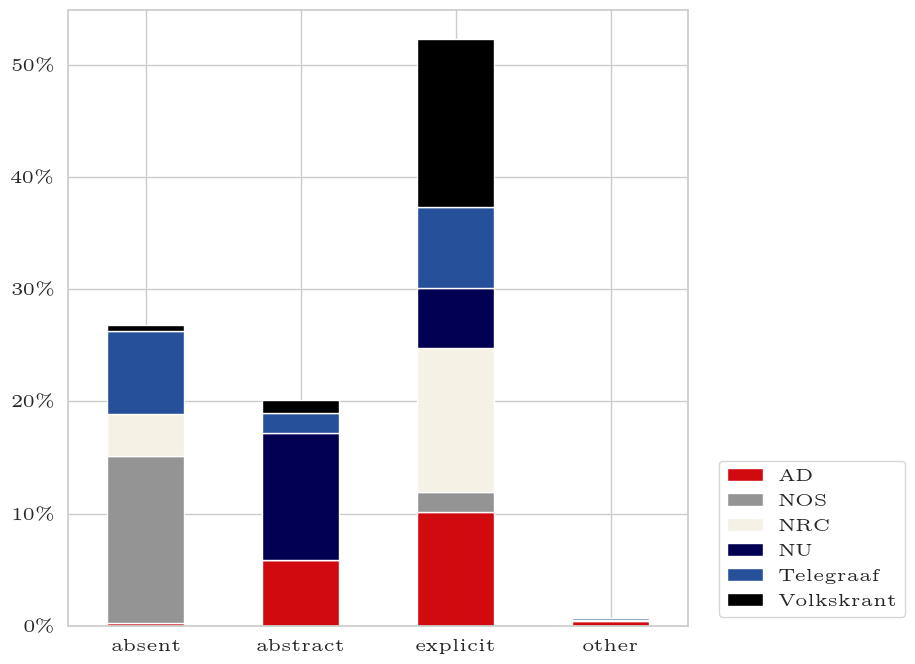

In [63]:
#We plot it for authors.
get_stacked_bar_chart("tp_authors")

In [64]:
#We print the prevalence numerically.
df.tp_authors.value_counts(normalize=True).reset_index()

,tp_authors,proportion
0,explicit,0.522992
1,absent,0.268047
2,abstract,0.201690
3,other,0.007270


In [65]:
#We also do so in a discrete version.
df.tp_authors.value_counts(normalize=False).reset_index()

,tp_authors,count
0,explicit,14171
1,absent,7263
2,abstract,5465
3,other,197


In [66]:
#We create a function to get a dichotomized percentual prevalence score for a class of interest.
def get_news_source_chances(col, cat, dec=2):
    #We group per outlet and get the percentual prevalence for the column of interest.
    tmp = df.groupby("news_source")[col].value_counts(normalize=True).unstack().loc[:, cat].reset_index()
    #We specifically extract the class of interest.
    tmp[cat] *= 100; tmp[cat] = round(tmp[cat].fillna(0), dec)
    #We add it to an overall value, disregarding the outlet difference.
    tmp.loc[len(tmp.index)] = ["overall", round(np.mean(tmp[cat].values), dec)]
    #We also add a column with the opposite value.
    tmp["remainder"] = 100 - tmp[cat]
    return tmp

In [68]:
#We print the above defined function for explicit authors.
get_news_source_chances(col="tp_authors", cat="explicit")

,news_source,explicit,remainder
0,AD,61.01,38.99
1,NOS,10.70,89.30
2,NRC,76.82,23.18
3,NU,31.95,68.05
4,Telegraaf,43.64,56.36
5,Volkskrant,89.68,10.32
6,overall,52.30,47.70


In [69]:
#We also do so for contact information.
get_news_source_chances(col="tp_contact", cat=True)

,news_source,True,remainder
0,AD,4.45,95.55
1,NOS,7.13,92.87
2,NRC,6.53,93.47
3,NU,0.53,99.47
4,Telegraaf,1.00,99.00
5,Volkskrant,0.75,99.25
6,overall,3.40,96.60


In [71]:
#We quickly investigate an interesting pattern where NOS rarely discloses authors, but if so, tends to disclosure contact info as well.
#We therefore calculate the correlation between these transparency dummies.
NOS = tp[tp.news_source=="NOS"]
np.round(np.corrcoef(NOS.tp_contact, NOS.tp_authors), 2)

array([[1.  , 0.79],
       [0.79, 1.  ]])

In [72]:
#We also print the values for contact bio.
get_news_source_chances(col="tp_bio", cat=True)

,news_source,True,remainder
0,AD,0.00,100.00
1,NOS,0.00,100.00
2,NRC,73.91,26.09
3,NU,0.09,99.91
4,Telegraaf,0.00,100.00
5,Volkskrant,89.59,10.41
6,overall,27.26,72.74


### errors

In [74]:
#We create a function to combine the update disclosures.
def get_error_combined(x):
    changed = x["changed_w_nos"]
    timestamp = x["tp_timestamp_w_nos"]
    text = x["tp_error"]
    
    #If there is no change, then that will be the category.
    if changed == False:
        return "no change"
    #If it did change we first assess if it is disclosed via text.
    elif changed == True:
        if text == "change disclosed":
            return "text"
        #As a lower tier we then asses if it otherwise is disclosed via timestamps.
        elif timestamp == "change disclosed":
            return "timestamp"
        #If not, it is not disclosed at all.
        else:
            return "undisclosed"

In [75]:
#We add it as a new column.
df["error_combined"] = df.progress_apply(lambda x: get_error_combined(x), axis=1)

100%|████████████████████████████████████████████████████████████████████████| 27096/27096 [00:00<00:00, 111024.68it/s]


In [76]:
#We count the prevalence of each category.
Counter(df.error_combined)

Counter({'undisclosed': 13740,
         'timestamp': 7703,
         'no change': 5442,
         'text': 211})

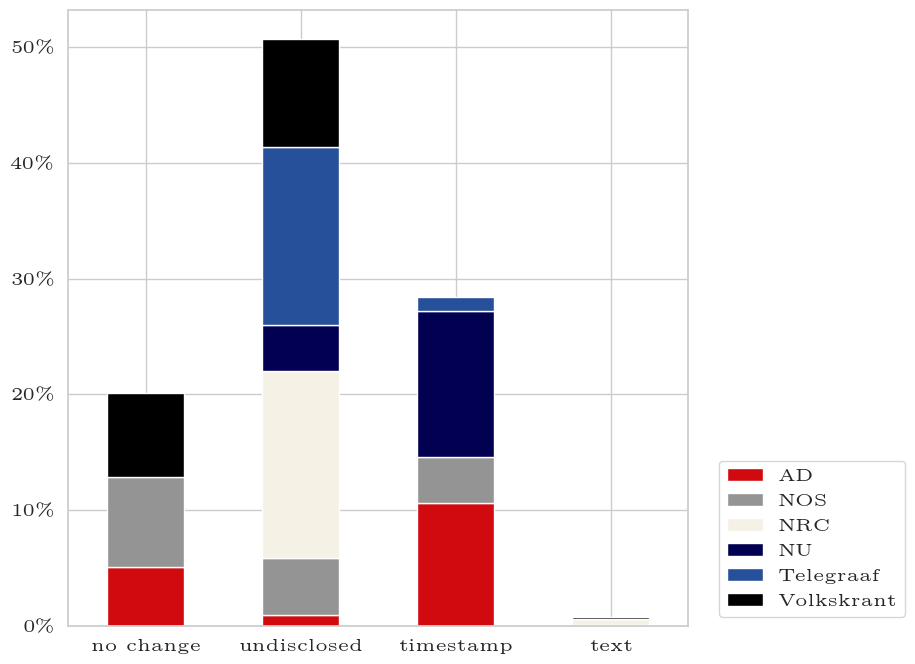

In [77]:
#We vizualize the prevalence.
get_stacked_bar_chart("error_combined", order=["no change", "undisclosed", "timestamp", "text"])

In [78]:
#We print the prevalence of undisclosure.
get_news_source_chances(col="error_combined", cat="undisclosed")

,news_source,undisclosed,remainder
0,AD,5.40,94.60
1,NOS,29.83,70.17
2,NRC,97.01,2.99
3,NU,23.72,76.28
4,Telegraaf,92.56,7.44
5,Volkskrant,55.74,44.26
6,overall,50.71,49.29


In [79]:
#And of timestamp disclosure.
get_news_source_chances(col="error_combined", cat="timestamp")

,news_source,timestamp,remainder
0,AD,63.91,36.09
1,NOS,23.38,76.62
2,NRC,0.00,100.00
3,NU,75.84,24.16
4,Telegraaf,7.44,92.56
5,Volkskrant,0.00,100.00
6,overall,28.43,71.57


In [80]:
#And of text disclosure.
get_news_source_chances(col="error_combined", cat="text")

,news_source,text,remainder
0,AD,0.13,99.87
1,NOS,0.18,99.82
2,NRC,2.99,97.01
3,NU,0.44,99.56
4,Telegraaf,0.00,100.00
5,Volkskrant,0.93,99.07
6,overall,0.78,99.22


### source transparency

In [84]:
#We have to create seperate dummy columns for opaque and anonymous sourcing.
tp["opaque_sourcing"] = tp.tp_sourcing.progress_apply(lambda x: 1 if x == "opaque" else 0)

100%|███████████████████████████████████████████████████████████████████████| 27096/27096 [00:00<00:00, 1551541.47it/s]
C:\Users\dubel\AppData\Local\Temp\ipykernel_9444\3099666740.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp["opaque_sourcing"] = tp.tp_sourcing.progress_apply(lambda x: 1 if x == "opaque" else 0)


In [85]:
Counter(tp.opaque_sourcing)

Counter({0: 23787, 1: 3309})

In [83]:
tp["anonymous_sourcing"] = tp.tp_sourcing.progress_apply(lambda x: 1 if x == "anonymous" else 0)

100%|███████████████████████████████████████████████████████████████████████| 27096/27096 [00:00<00:00, 1609666.04it/s]
C:\Users\dubel\AppData\Local\Temp\ipykernel_9444\1503567697.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp["anonymous_sourcing"] = tp.tp_sourcing.progress_apply(lambda x: 1 if x == "anonymous" else 0)


In [86]:
Counter(tp.anonymous_sourcing)

Counter({0: 27046, 1: 50})

In [87]:
#We define all possible sourcing columns.
sourcing_categories = ["tp_internal", "tp_family", "tp_external", "tp_document", "explicit_sourcing", "opaque_sourcing", "anonymous_sourcing"]

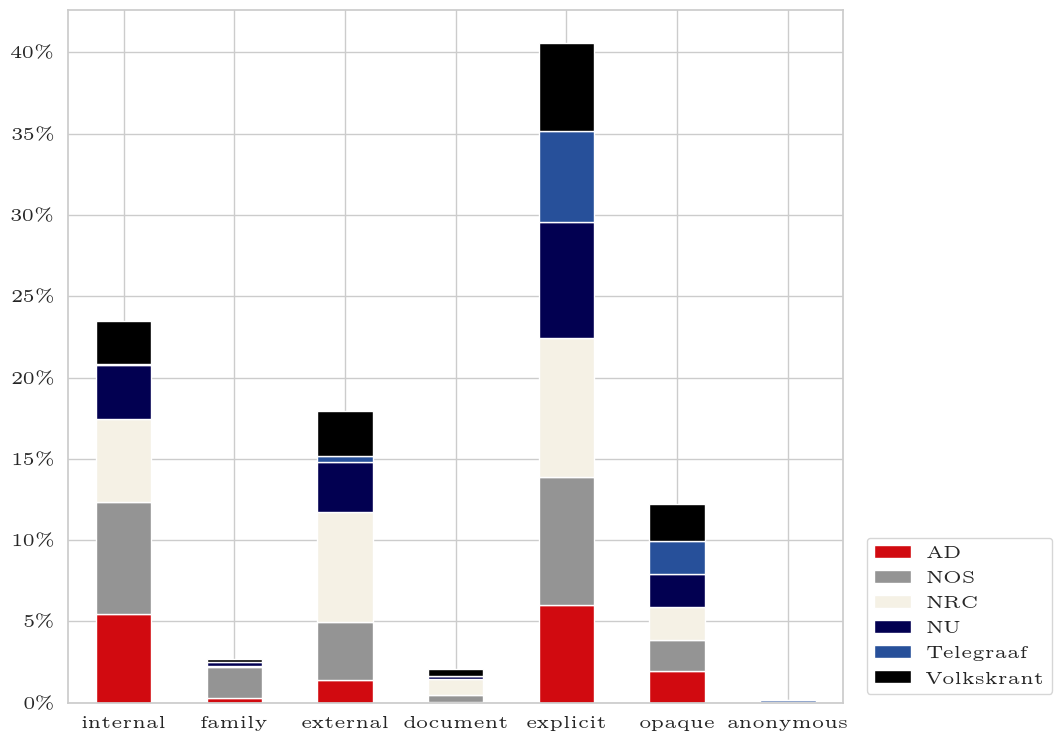

In [88]:
#We vizualize them.
get_stacked_bar_chart(sourcing_categories,data=tp, labels=["internal", "family", "external", "document", "explicit", "opaque", "anonymous"], size=(10,9), anchor=1.15)

In [89]:
#We calculate the means overall in terms of prevalence of each column.
tp[sourcing_categories].mean().mul(100).round(2).transpose().reset_index(name="mean")

,index,mean
0,tp_internal,23.45
1,tp_family,2.69
2,tp_external,17.97
3,tp_document,2.07
4,explicit_sourcing,40.59
5,opaque_sourcing,12.21
6,anonymous_sourcing,0.18


In [90]:
#We also calculate them per outlet.
tp.groupby("news_source")[sourcing_categories].mean().mul(100).round(2).transpose()

news_source,AD,NOS,NRC,NU,Telegraaf,Volkskrant
tp_internal,32.75,41.43,30.47,19.82,0.44,15.77
tp_family,1.88,11.27,0.58,1.22,0.00,1.17
tp_external,8.41,21.46,40.48,18.40,2.24,16.83
tp_document,0.42,2.35,5.91,1.26,0.02,2.48
explicit_sourcing,36.09,47.14,51.48,42.58,33.77,32.44
opaque_sourcing,11.82,11.38,12.09,12.33,12.18,13.46
anonymous_sourcing,0.11,0.02,0.07,0.09,0.64,0.18


### process transparency

In [91]:
#We calculate the overall process info factor.
round(df["process_info_factor"].mean()*100,2)

0.39

In [92]:
#And we calculate it per outlet.
df.groupby("news_source")["process_info_factor"].mean().mul(100).round(2).transpose().reset_index(name="mean")

,news_source,mean
0,AD,0.25
1,NOS,0.13
2,NRC,0.95
3,NU,0.62
4,Telegraaf,0.22
5,Volkskrant,0.14


## analysis

### analysis > author transparency

In [93]:
#We create a list of all our predictors, which are equal for all dimension analyses.
predictors = "C(np_mode, Treatment(reference='multimodal')) + np_funding + C(np_quality, Treatment(reference='popular')) + C(p_article_softness, Treatment(reference='soft')) + text_length + peak_hour + weekend"

In [94]:
#We define a function to create analyses output.
def get_output(y, x=predictors, model="OLS", data=tp):
    #We firstly define a simple formula which we can input with x (the predictor list) and the y of interest.
    formula = f"{y} ~ {x}"
    #We can either choose between an OLS, Beta or Poisson modelling.
    if model == "OLS":
        md = smf.ols(formula, data)
    elif model == "Beta":
        #In the case of a Beta regresison we have to truncate our values, since it can not handle edge values of 0 or 1.
        N = len(data)
        y_sq = y + "_sq"; data[y_sq] = data[y].apply(lambda x: (x*(N-1)+.5)/(N)); y = y_sq
        md = BetaModel.from_formula(f"{y} ~ {x}", data)
    elif model == "Poisson":
        md = smf.glm(f"{y} ~ {x}", data, family=sm.families.Poisson())
    #We fit the chosen model.
    mdf = md.fit()
    #We get a summary output of it.
    summary = mdf.summary()
    #We extract the regression table.
    coef_table = summary.tables[1]
    #We transform it to a dataframe.
    coef_data = pd.DataFrame(coef_table.data, columns=coef_table.data[0])
    coef_data = coef_data.drop(0)
    
    #For the OLS we depend  on t values, whereas the other models use z statistics.
    p_col = "P>|t|" if model == "OLS" else "P>|z|"
    
    #We extract the relevant statistics.
    coef_data = coef_data[["coef", "std err", p_col]][:8]
    #We name the features of interest.
    coef_data["feature"] = ["Intercept", 
                            "origin [digital native]", "funding [public]", "profile [quality]", "article type [hard]",
                            "peak hour [yes]", "weekend [yes]", "text length"]
    #We set these names as the index and remove the numeric index.
    coef_data.set_index("feature", inplace=True)    
    coef_data.index.name=None
    #We rename the columns of interest.
    coef_data.rename(columns={"coef":"$B$", "std err":"$se$", p_col:"$p$"}, inplace=True)
    #We round the statistics.
    coef_data[["$B$", "$se$"]] = coef_data[["$B$", "$se$"]].astype(float).apply(lambda x: round(x, 2))
    
    #We print it as a latex table and print the summary.
    print(coef_data.to_latex(float_format="%.2f"))
    print(summary)
    
    #We extract the degrees of freedom.
    df = f"({round(mdf.df_model)}, {round(mdf.df_resid)})"
    #We either extract the F value or Pearson Chisquared depending on the model.
    t_stat_txt = f"F{df} = {round(mdf.fvalue,2)}" if model == "OLS" else f"\chi^2{df} = {round(mdf.pearson_chi2,2)}"
    #Similarly we either extrract the R squared or the pseudo version depending on the model.
    r2_txt = f"R^2 = {round(mdf.rsquared,2)}" if model == "OLS" else f"pseudo$-$R^2 = {round(mdf.pseudo_rsquared(),2)}"
    
    if model == "Beta":
        data.drop(columns=[y_sq], inplace=True)
    
    #We print the model summary statistics.
    else:
        print(f"$N = {round(mdf.nobs)}, {t_stat_txt}, {r2_txt}.$")
    
    return coef_data

In [96]:
#We print the outputs for each dimension, firstly the weighted version through OLS, and then the Poisson for the discrete index.
get_output("author_transparency_w")

\begin{tabular}{lrrl}
\toprule
 & $B$ & $se$ & $p$ \\
\midrule
Intercept & 0.09 & 0.00 &  0.000 \\
origin [digital native] & -0.07 & 0.00 &  0.000 \\
funding [public] & -0.41 & 0.00 &  0.000 \\
profile [quality] & 0.31 & 0.00 &  0.000 \\
article type [hard] & 0.01 & 0.00 &  0.000 \\
peak hour [yes] & -0.01 & 0.00 &  0.000 \\
weekend [yes] & -0.01 & 0.00 &  0.013 \\
text length & 0.00 & 0.00 &  0.000 \\
\bottomrule
\end{tabular}

                              OLS Regression Results                             
Dep. Variable:     author_transparency_w   R-squared:                       0.593
Model:                               OLS   Adj. R-squared:                  0.593
Method:                    Least Squares   F-statistic:                     5630.
Date:                   Sun, 28 Jan 2024   Prob (F-statistic):               0.00
Time:                           14:11:30   Log-Likelihood:                 11115.
No. Observations:                  27096   AIC:                        -2.2

,$B$,$se$,$p$
Intercept,0.09,0.0,0.000
origin [digital native],-0.07,0.0,0.000
funding [public],-0.41,0.0,0.000
profile [quality],0.31,0.0,0.000
article type [hard],0.01,0.0,0.000
peak hour [yes],-0.01,0.0,0.000
weekend [yes],-0.01,0.0,0.013
text length,0.00,0.0,0.000


In [97]:
Counter(tp.author_transparency)

Counter({0.0: 12520, 2.0: 7720, 1.0: 6764, 3.0: 92})

In [98]:
get_output("author_transparency", model="Poisson")

\begin{tabular}{lrrl}
\toprule
 & $B$ & $se$ & $p$ \\
\midrule
Intercept & -0.78 & 0.02 &  0.000 \\
origin [digital native] & -0.58 & 0.03 &  0.000 \\
funding [public] & -2.14 & 0.04 &  0.000 \\
profile [quality] & 0.95 & 0.02 &  0.000 \\
article type [hard] & 0.06 & 0.02 &  0.000 \\
peak hour [yes] & -0.02 & 0.02 &  0.153 \\
weekend [yes] & -0.01 & 0.02 &  0.450 \\
text length & 0.00 & 0.00 &  0.000 \\
\bottomrule
\end{tabular}

                  Generalized Linear Model Regression Results                  
Dep. Variable:     author_transparency   No. Observations:                27096
Model:                             GLM   Df Residuals:                    27088
Model Family:                  Poisson   Df Model:                            7
Link Function:                     Log   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -25599.
Date:                 Sun, 28 Jan 2024   Deviance:                       17217.
Time: 

,$B$,$se$,$p$
Intercept,-0.78,0.02,0.000
origin [digital native],-0.58,0.03,0.000
funding [public],-2.14,0.04,0.000
profile [quality],0.95,0.02,0.000
article type [hard],0.06,0.02,0.000
peak hour [yes],-0.02,0.02,0.153
weekend [yes],-0.01,0.02,0.450
text length,0.00,0.00,0.000


### analysis > error transparency

In [100]:
#As for the update analyses we exclude the unchanged articles.
Counter(tp[tp.changed_w_nos==True].error_transparency)

Counter({0.0: 13740, 1.0: 7883, 2.0: 31})

In [101]:
get_output("error_transparency_w", data = tp[tp.changed_w_nos==True])

\begin{tabular}{lrrl}
\toprule
 & $B$ & $se$ & $p$ \\
\midrule
Intercept & 0.17 & 0.00 &  0.000 \\
origin [digital native] & 0.14 & 0.00 &  0.000 \\
funding [public] & 0.19 & 0.00 &  0.000 \\
profile [quality] & -0.20 & 0.00 &  0.000 \\
article type [hard] & -0.01 & 0.00 &  0.000 \\
peak hour [yes] & -0.02 & 0.00 &  0.000 \\
weekend [yes] & 0.01 & 0.00 &  0.014 \\
text length & 0.00 & 0.00 &  0.000 \\
\bottomrule
\end{tabular}

                             OLS Regression Results                             
Dep. Variable:     error_transparency_w   R-squared:                       0.329
Model:                              OLS   Adj. R-squared:                  0.329
Method:                   Least Squares   F-statistic:                     1518.
Date:                  Sun, 28 Jan 2024   Prob (F-statistic):               0.00
Time:                          14:11:55   Log-Likelihood:                 6873.9
No. Observations:                 21654   AIC:                        -1.373e+04
D

,$B$,$se$,$p$
Intercept,0.17,0.0,0.000
origin [digital native],0.14,0.0,0.000
funding [public],0.19,0.0,0.000
profile [quality],-0.20,0.0,0.000
article type [hard],-0.01,0.0,0.000
peak hour [yes],-0.02,0.0,0.000
weekend [yes],0.01,0.0,0.014
text length,0.00,0.0,0.000


In [102]:
get_output("error_transparency", data = tp[tp.changed_w_nos==True], model="Poisson")

\begin{tabular}{lrrl}
\toprule
 & $B$ & $se$ & $p$ \\
\midrule
Intercept & -0.99 & 0.03 &  0.000 \\
origin [digital native] & 0.53 & 0.02 &  0.000 \\
funding [public] & 2.98 & 0.08 &  0.000 \\
profile [quality] & -3.02 & 0.08 &  0.000 \\
article type [hard] & -0.09 & 0.02 &  0.000 \\
peak hour [yes] & -0.09 & 0.02 &  0.000 \\
weekend [yes] & 0.02 & 0.03 &  0.434 \\
text length & 0.00 & 0.00 &  0.000 \\
\bottomrule
\end{tabular}

                 Generalized Linear Model Regression Results                  
Dep. Variable:     error_transparency   No. Observations:                21654
Model:                            GLM   Df Residuals:                    21646
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12969.
Date:                Sun, 28 Jan 2024   Deviance:                       10092.
Time:         

,$B$,$se$,$p$
Intercept,-0.99,0.03,0.000
origin [digital native],0.53,0.02,0.000
funding [public],2.98,0.08,0.000
profile [quality],-3.02,0.08,0.000
article type [hard],-0.09,0.02,0.000
peak hour [yes],-0.09,0.02,0.000
weekend [yes],0.02,0.03,0.434
text length,0.00,0.00,0.000


### analysis > sourcing transparency

In [103]:
get_output("sourcing_transparency_w")

\begin{tabular}{lrrl}
\toprule
 & $B$ & $se$ & $p$ \\
\midrule
Intercept & 0.06 & 0.00 &  0.000 \\
origin [digital native] & 0.05 & 0.00 &  0.000 \\
funding [public] & 0.08 & 0.00 &  0.000 \\
profile [quality] & 0.05 & 0.00 &  0.000 \\
article type [hard] & 0.09 & 0.00 &  0.000 \\
peak hour [yes] & 0.00 & 0.00 &  0.864 \\
weekend [yes] & -0.02 & 0.00 &  0.000 \\
text length & 0.00 & 0.00 &  0.000 \\
\bottomrule
\end{tabular}

                               OLS Regression Results                              
Dep. Variable:     sourcing_transparency_w   R-squared:                       0.139
Model:                                 OLS   Adj. R-squared:                  0.139
Method:                      Least Squares   F-statistic:                     625.0
Date:                     Sun, 28 Jan 2024   Prob (F-statistic):               0.00
Time:                             14:12:06   Log-Likelihood:                 6429.8
No. Observations:                    27096   AIC:                 

,$B$,$se$,$p$
Intercept,0.06,0.0,0.000
origin [digital native],0.05,0.0,0.000
funding [public],0.08,0.0,0.000
profile [quality],0.05,0.0,0.000
article type [hard],0.09,0.0,0.000
peak hour [yes],0.00,0.0,0.864
weekend [yes],-0.02,0.0,0.000
text length,0.00,0.0,0.000


In [104]:
Counter(tp.sourcing_transparency)

Counter({0.0: 11052, 1.0: 10180, 2.0: 4577, 3.0: 1198, 4.0: 89})

In [105]:
get_output("sourcing_transparency", model="Poisson")

\begin{tabular}{lrrl}
\toprule
 & $B$ & $se$ & $p$ \\
\midrule
Intercept & -0.94 & 0.02 &  0.000 \\
origin [digital native] & 0.29 & 0.02 &  0.000 \\
funding [public] & 0.34 & 0.02 &  0.000 \\
profile [quality] & 0.30 & 0.02 &  0.000 \\
article type [hard] & 0.52 & 0.02 &  0.000 \\
peak hour [yes] & -0.00 & 0.02 &  0.905 \\
weekend [yes] & -0.09 & 0.02 &  0.000 \\
text length & 0.00 & 0.00 &  0.000 \\
\bottomrule
\end{tabular}

                   Generalized Linear Model Regression Results                   
Dep. Variable:     sourcing_transparency   No. Observations:                27096
Model:                               GLM   Df Residuals:                    27088
Model Family:                    Poisson   Df Model:                            7
Link Function:                       Log   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -30737.
Date:                   Sun, 28 Jan 2024   Deviance:                       2

,$B$,$se$,$p$
Intercept,-0.94,0.02,0.000
origin [digital native],0.29,0.02,0.000
funding [public],0.34,0.02,0.000
profile [quality],0.30,0.02,0.000
article type [hard],0.52,0.02,0.000
peak hour [yes],-0.00,0.02,0.905
weekend [yes],-0.09,0.02,0.000
text length,0.00,0.00,0.000


### analysis > process transparency

In [106]:
tp.process_info_factor.describe()

count    27096.000000
mean         0.006060
std          0.037439
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: process_info_factor, dtype: float64

In [107]:
get_output("process_info_factor")

\begin{tabular}{lrrl}
\toprule
 & $B$ & $se$ & $p$ \\
\midrule
Intercept & 0.00 & 0.00 &  0.000 \\
origin [digital native] & 0.01 & 0.00 &  0.000 \\
funding [public] & -0.01 & 0.00 &  0.000 \\
profile [quality] & 0.01 & 0.00 &  0.000 \\
article type [hard] & 0.00 & 0.00 &  0.000 \\
peak hour [yes] & 0.00 & 0.00 &  0.000 \\
weekend [yes] & -0.00 & 0.00 &  0.764 \\
text length & -0.00 & 0.00 &  0.000 \\
\bottomrule
\end{tabular}

                             OLS Regression Results                            
Dep. Variable:     process_info_factor   R-squared:                       0.016
Model:                             OLS   Adj. R-squared:                  0.016
Method:                  Least Squares   F-statistic:                     62.56
Date:                 Sun, 28 Jan 2024   Prob (F-statistic):           9.70e-90
Time:                         14:12:13   Log-Likelihood:                 50782.
No. Observations:                27096   AIC:                        -1.015e+05
Df Resid

,$B$,$se$,$p$
Intercept,0.00,0.0,0.000
origin [digital native],0.01,0.0,0.000
funding [public],-0.01,0.0,0.000
profile [quality],0.01,0.0,0.000
article type [hard],0.00,0.0,0.000
peak hour [yes],0.00,0.0,0.000
weekend [yes],-0.00,0.0,0.764
text length,-0.00,0.0,0.000


### multiverse

In [109]:
#We create a function to retrieve readable names for each main predictor as well as for each transparency dummy.
#With it we also return the dimension to which the dummy belongs.
def get_names(x):
    predictor = x["x"]
    effect = x["y"]
    
    if predictor == "np_funding[T.public]":
        p_name = "public funding [yes]"
    elif predictor == "C(np_mode, Treatment(reference='multimodal'))[T.digital native]":
        p_name = "digital native [yes]"
    elif predictor == "C(np_quality, Treatment(reference='popular'))[T.quality]":
        p_name = "quality [yes]"
    else:
        p_name = "hard news [yes]"
        
    if effect == "tp_authors":
        e_name = "explicit author [yes]"; dimension = "author"
    elif effect == "tp_contact":
        e_name = "contact info [yes]"; dimension = "author"
    elif effect == "tp_bio":
        e_name = "bio info [yes]"; dimension = "author"
    elif effect == "tp_timestamp_w_nos":
        e_name = "timestamp disclosure [yes]"; dimension = "update"
    elif effect == "tp_error":
        e_name = "text disclosure [yes]"; dimension = "update"
    elif effect == "tp_internal":
        e_name = "internal linking [yes]"; dimension = "source"
    elif effect == "tp_family":
        e_name = "family linking [yes]"; dimension = "source"
    elif effect == "tp_external":
        e_name = "external linking [yes]"; dimension = "source"
    elif effect == "tp_document":
        e_name = "document linking [yes]"; dimension = "source"
    elif effect == "explicit_sourcing":
        e_name = "explicit sourcing [yes]"; dimension = "source"
    elif effect == "tp_process_info":
        e_name = "process info [yes]"; dimension = "production"
                
    return p_name, e_name, dimension
        
#We create a function to perform logistic analyses for each dummy.
def get_coefficients(y, x=predictors):
    #We define our function and model.
    md = smf.logit(f"{y} ~ {x}", tp)
    mdf = md.fit()
    #We extract the rgression coefficients.
    summary = round(mdf.summary2().tables[1],2).reset_index()
    #We rename the statistics.
    summary.rename(columns={"index": "x", 
                            "Coef.": "B",
                            "[0.025": "lb",
                            "0.975]": "ub"}, inplace=True)
    #We keep all that we need.
    summary = summary[1:5][["x", "B", "lb", "ub"]]
    meta = mdf.summary2().tables[0]
    #We extract the y of the model.
    summary["y"] = meta[[1]][1:2].values[0][0]
    #We extract whether the model converged yes or no.
    summary["converged"] = meta[[1]][6:7].values[0][0]
    #We rename the values through the naming function defined above.
    summary[["x", "y", "dimension"]] = summary.apply(lambda x: pd.Series(get_names(x)), axis=1)
    
    return summary

In [110]:
lst = ["tp_authors", "tp_contact", "tp_bio",
       "tp_timestamp_w_nos", "tp_error",
       "tp_internal", "tp_external", "tp_document", "tp_family",
       "explicit_sourcing", 
       "tp_process_info"]

results = pd.DataFrame()

#We loop over every transparency dummy and try to estimate the logistic model and append the results to a dataframe.
for item in lst:
    try:
        print(item.upper())
        tmp = get_coefficients(item)
        results = pd.concat([tmp, results], axis=0)
    except:
        pass

TP_AUTHORS
Optimization terminated successfully.
         Current function value: 0.491451
         Iterations 6
TP_CONTACT
Optimization terminated successfully.
         Current function value: 0.138817
         Iterations 9
TP_BIO
         Current function value: 0.141736
         Iterations: 35
TP_TIMESTAMP_W_NOS


C:\Users\dubel\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dubel\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\dubel\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


         Current function value: inf
         Iterations: 35
TP_ERROR
Optimization terminated successfully.
         Current function value: 0.039943
         Iterations 11
TP_INTERNAL
Optimization terminated successfully.
         Current function value: 0.510709
         Iterations 6
TP_EXTERNAL
Optimization terminated successfully.
         Current function value: 0.421712
         Iterations 7
TP_DOCUMENT
Optimization terminated successfully.
         Current function value: 0.085856
         Iterations 10
TP_FAMILY
Optimization terminated successfully.
         Current function value: 0.096432
         Iterations 9
EXPLICIT_SOURCING
Optimization terminated successfully.
         Current function value: 0.639280
         Iterations 5
TP_PROCESS_INFO
Optimization terminated successfully.
         Current function value: 0.188345
         Iterations 8


In [111]:
#We sort the results of this multiverse analysis.
results.sort_values("x", inplace=True); results.reset_index(drop=True, inplace=True); results

,x,B,lb,ub,y,converged,dimension
0,digital native [yes],1.63,1.46,1.80,process info [yes],1.0000,production
1,digital native [yes],-1.26,-1.34,-1.18,explicit author [yes],1.0000,author
2,digital native [yes],-1.76,-2.18,-1.34,contact info [yes],1.0000,author
3,digital native [yes],0.30,0.22,0.37,explicit sourcing [yes],1.0000,source
4,digital native [yes],11.90,-268.51,292.31,bio info [yes],0.0000,author
5,digital native [yes],0.23,-0.12,0.57,family linking [yes],1.0000,source
6,digital native [yes],1.74,0.82,2.65,text disclosure [yes],1.0000,update
7,digital native [yes],0.10,0.01,0.19,internal linking [yes],1.0000,source
8,digital native [yes],1.52,1.00,2.03,document linking [yes],1.0000,source
9,digital native [yes],1.29,1.17,1.41,external linking [yes],1.0000,source


In [113]:
#We specificy the order.
y_order = ["explicit author [yes]", "contact info [yes]", 
           "timestamp disclosure [yes]", "text disclosure [yes]",
           "internal linking [yes]", "family linking [yes]", "external linking [yes]", "document linking [yes]",
           "explicit sourcing [yes]",
           "process info [yes]"]

In [114]:
#We exclude the wrongly converged models.
results_wo_bio = results[results.y !=  "bio info [yes]"].sort_values(by="y", key=lambda x: x.map({v: -i for i, v in enumerate(y_order)}))

In [115]:
#We specify the order of the facets.
facet_order = ["public funding [yes]", "digital native [yes]", "quality [yes]", "hard news [yes]"]

In [116]:
#We specify the colors used.
custom_palette = ["#FFD098", "#14A5B6", "#D61F33", "#8BE1AF"]

C:\Users\dubel\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\dubel\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


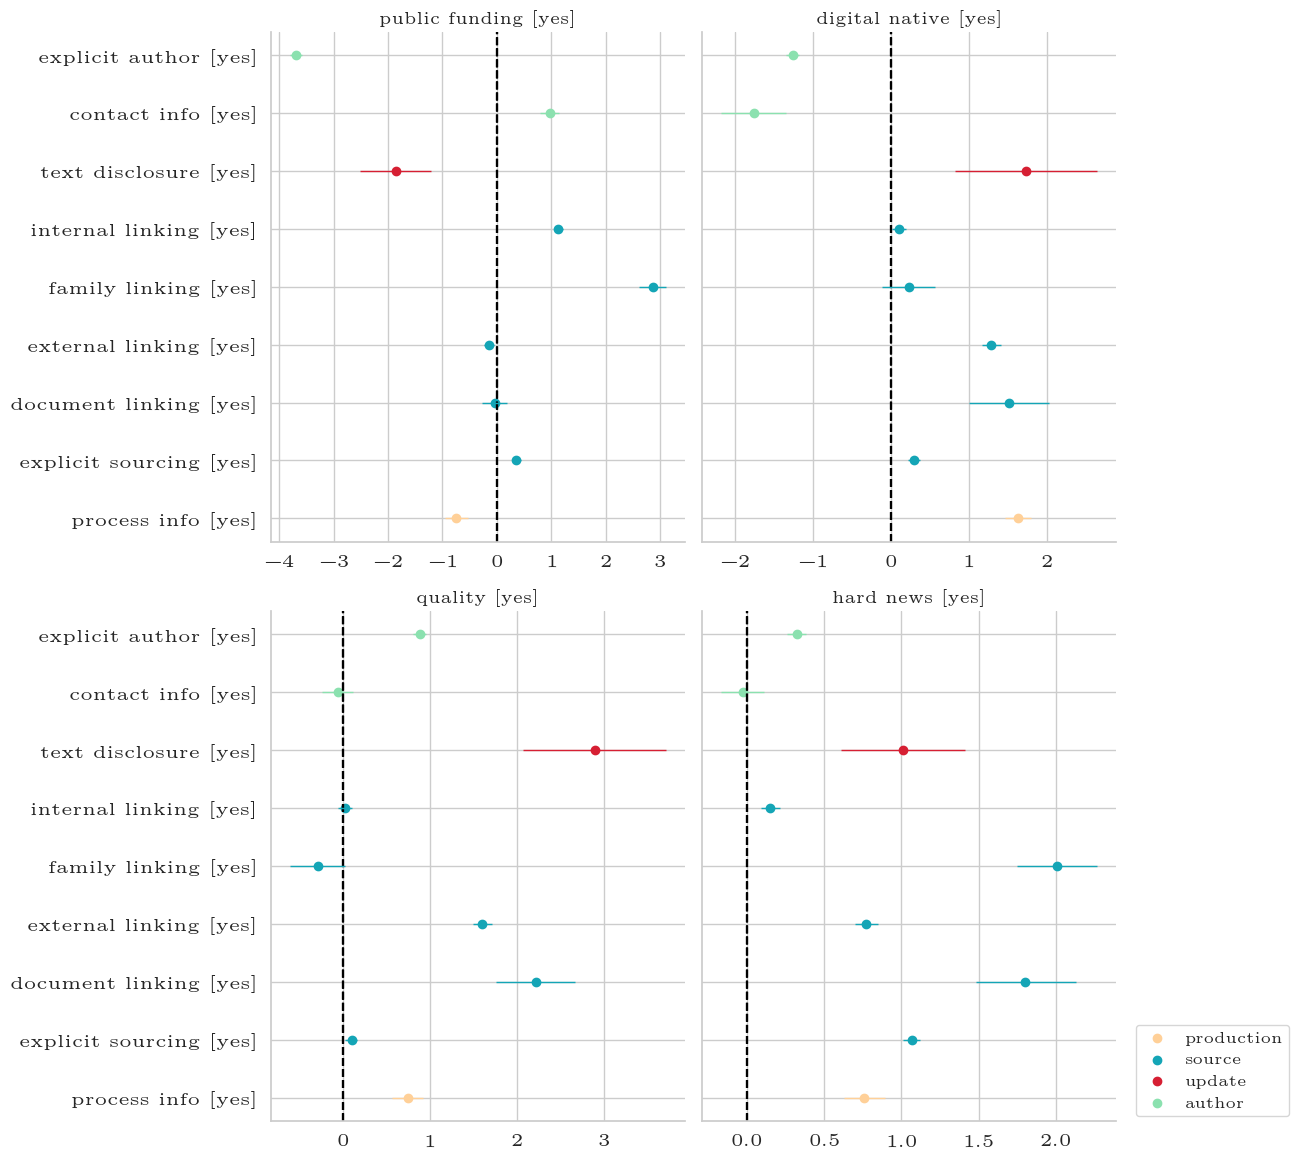

In [117]:
results_wo_bio["facet_col"] = results_wo_bio["x"]

#We define our font.
plt.rcParams['font.family'] = ['Latin Modern Roman']
#We specify our style and plot the effect for each main predictor on each dummy.
g = sns.FacetGrid(results_wo_bio, col="facet_col", col_wrap=2, height=6, sharex=False, col_order=facet_order,
                 hue="dimension", palette=custom_palette)

sns.set(font_scale=1, style="whitegrid")

#We add a line for 0.
g.map(plt.axvline, x=0, linestyle="--", color="black")
g.map_dataframe(plt.hlines, y="y", xmin="lb", xmax="ub", linewidth=1)
g.map(plt.scatter, "B", "y", marker="o")

plt.rcParams['font.family'] = ['Latin Modern Roman']
g.add_legend(title="", bbox_to_anchor=(1.01, 0.1), ncol=1, frameon=True, fancybox=True)

g.set_axis_labels("", "")
g.set_titles(col_template="{col_name}")

plt.savefig(f"transparency_multiverse.pdf", format="pdf", bbox_inches="tight")

In [118]:
#W write away the results.
results.to_csv("multiverse_results.csv")

### fe transparency index ! see R script

In [119]:
#We create a function that creates nested section names within outlet.
#As well as nested author names, within section, within outlet.
#We simply do so by appending the strings.
def get_nested_section_and_author(x):
    source = str(x["news_source"])
    section = str(x["section_clean"])
    author = str(x["author_clean"])
    
    nested_section = source + "_" + section
    nested_author = author + "_" + nested_section
    
    return nested_section, nested_author

In [120]:
#We apply the function.
tp[["nested_section", "nested_author"]] = tp.progress_apply(lambda x: pd.Series(get_nested_section_and_author(x)), axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 27096/27096 [00:03<00:00, 9013.06it/s]
C:\Users\dubel\AppData\Local\Temp\ipykernel_9444\3062151948.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp[["nested_section", "nested_author"]] = tp.progress_apply(lambda x: pd.Series(get_nested_section_and_author(x)), axis=1)
C:\Users\dubel\AppData\Local\Temp\ipykernel_9444\3062151948.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp[["nested_section", "nested_author"]] = tp.

In [121]:
#We extract all variables that we need.
fe_tp = tp[["transparency_index", "news_source", "nested_section", "nested_author", "dateMonth"]]

In [122]:
#We quickly calculate the mean transparency index scores per outlet.
fe_tp.groupby("news_source").transparency_index.mean()

news_source
AD            0.228665
NOS           0.190795
NRC           0.334506
NU            0.229099
Telegraaf     0.086849
Volkskrant    0.267309
Name: transparency_index, dtype: float64

In [123]:
#We calculate the prevalence of the authors.
authors = fe_tp["nested_author"].value_counts()

In [124]:
#We indicate the rows of nested authors that only occur once.
rare_authors_rows = fe_tp["nested_author"].isin(authors[authors == 1].index)

In [125]:
#We exclude these rare authors.
fe_tp_2 = fe_tp[~rare_authors_rows]

In [127]:
#We validate that now indeed 
fe_tp_2.nested_section.value_counts().min()

2

In [126]:
#We write this data away.
fe_tp_2.to_csv("nested_transparency.csv")

## bin

In [110]:
df_int = pd.DataFrame({"category": ["fixed", "random", "news source", "section", "author"],
                       "percentage": [100, 63, 38, 10, 18]})
df_int = df_int.sort_values(by="percentage", ascending=False)
int_palette = ["darkgrey", "lightgrey", "lightsteelblue", "royalblue", "cornflowerblue"]

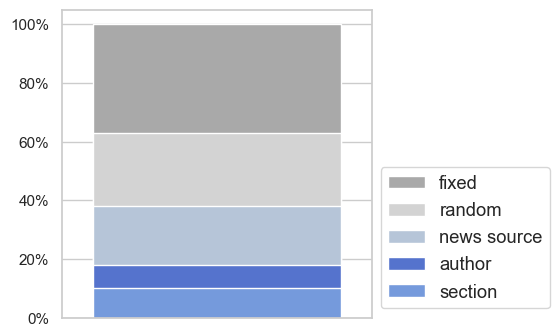

In [111]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.set(font_scale=1.2, palette=custom_palette, style="whitegrid")
sns.barplot(y="percentage", hue="category", data=df_int, palette=int_palette, dodge=False)
ax.legend(bbox_to_anchor=(1.3, 0), loc="lower center", ncol=1)
ax.set_ylabel("")
def format_n(value, _):
    return f"{value:.0f}%"
ax.yaxis.set_major_formatter(FuncFormatter(format_n))
plt.xticks(rotation=0)
plt.savefig("int_analysis.pdf", format="pdf", bbox_inches="tight")

In [ ]:
from sklearn.preprocessing import normalize
data_scaled = normalize(test)
data_scaled = pd.DataFrame(data_scaled, columns=test.columns)
data_scaled.head()

In [ ]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))

In [ ]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
test = cluster.fit_predict(data_scaled)

In [ ]:
df["cluster"] = test

In [ ]:
df.cluster

In [ ]:
plt.figure(figsize=(10, 7))  
plt.scatter(data_scaled['Milk'], data_scaled['Grocery'], c=cluster.labels_) 

In [ ]:
# Assuming results_wo_bio is your DataFrame
results_wo_bio["facet_col"] = results_wo_bio["x"]

# Specify the order of outer and inner facets
  # Replace with your actual inner facet values

# Create a FacetGrid with nested facets
g = sns.FacetGrid(results_wo_bio, col="facet_col", 
                  row="dimension",
                  height=4, aspect=1.5, sharey=False)

sns.set(font_scale=1, style="whitegrid")

# Map hlines, scatter plot, and axvline to each facet
g.map_dataframe(plt.hlines, y="y", xmin="lb", xmax="ub", color='black', linewidth=1)
g.map(plt.scatter, "B", "y", color='black', marker='o')
g.map(plt.axvline, x=0, linestyle="--", color="red", linewidth=1)

# Customize appearance
g.set_axis_labels("", "")
g.set_titles(col_template="{col_name}", row_template="{row_name}")

# Show the plot
plt.show()